In [4]:
import Pkg; Pkg.activate(joinpath(@__DIR__, ".."))
using AtomsBuilder
using ComponentArrays
using DFTK
using ForwardDiff
using LinearAlgebra
using Plots
using PseudoPotentialData
using Random
using Unitful
using UnitfulAtomic

  Activating project at `~/git/tutorial-cecam-workshop-dftk-2025`


# Defining a custom XC functional in DftFunctionals.jl

It is easy to define a new exchange-correlation functional and use it with DFTK.
Defining an energy expression is sufficient: We will use ForwardDiff
to automatically compute exchange-correlation energy derivatives of 
- first-order (for SCF): the XC potential $V_\text{xc} = \frac{\partial E_\text{xc}}{\partial \rho}$, and
- second-order (for DFPT): the XC kernel $\frac{\partial V_\text{xc}}{\partial \rho}$, and the potential-parameter-derivative $\frac{\partial V_\text{xc}}{\partial \theta}$

(*Technical remark: Currently this functionality is limited to GGA-type functionals.*)

In [5]:
include("beef.jl")  # see this file for the BEEF functional implementation in few lines

Main.Beef

Let's visualize the exchange-enhancement factor ensemble (as Fig 1. in https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.95.216401)

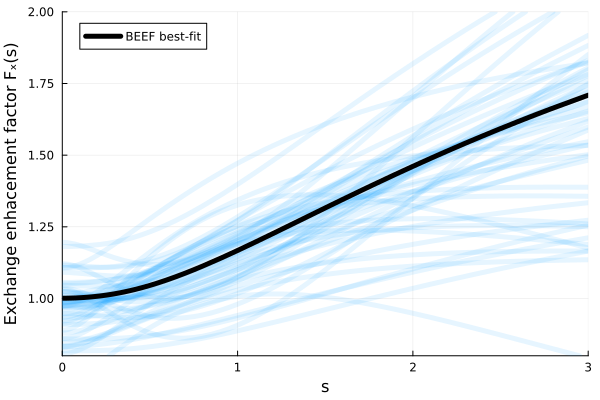

In [3]:
let 
    params = Beef.params_beef_2005()
    rng = MersenneTwister(1234)
    n_samples = 50
    α = randn(rng, 3, n_samples)
    δθ_ensemble = params.L * α
    fig_fx_ensemble = plot(xlim=(0,3), ylim=(0.8, 2.0), xlabel="s", ylabel="Exchange enhacement factor Fₓ(s)")
    for δθ in eachcol(δθ_ensemble)
        plot!(fig_fx_ensemble, s -> Beef.f_x_beef(s, params.θ_bf + δθ), label=nothing,
        color=1, linealpha=0.1, lw=5)
    end
    plot!(fig_fx_ensemble, s -> Beef.f_x_beef(s, params.θ_bf), label="BEEF best-fit",
    linewidth=5, color=:black)
    fig_fx_ensemble
end

## Using the custom XC functional in DFTK

In [6]:
params = Beef.params_beef_2005()
make_functionals(θ) = Beef.make_beef(θ)
functionals = make_functionals(params.θ_bf)

2-element Vector{DftFunctionals.Functional{:gga}}:
 gga_c_pbe
 gga_x_beef_custom

In [10]:
a0_beef = 10.328164895118894  # From a prior geometry relaxation
a0 = a0_beef
system = bulk(:Si; a=a0_beef * u"bohr")

# Set up DFT model
pseudopotentials = PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
(; lattice, atoms, positions) = DFTK.parse_system(system, pseudopotentials)
model = model_DFT(lattice, atoms, positions; functionals, temperature=1e-3)
symmetries = model.symmetries

# Discretization
Ecut = recommended_cutoff(model).Ecut
kgrid = (8, 8, 8)
basis = PlaneWaveBasis(model; Ecut, kgrid)

PlaneWaveBasis discretization:
    architecture         : DFTK.CPU()
    num. mpi processes   : 1
    num. julia threads   : 1
    num. DFTK  threads   : 1
    num. blas  threads   : 6
    num. fft   threads   : 1

    Ecut                 : 18.0 Ha
    fft_size             : (32, 32, 32), 32768 total points
    kgrid                : MonkhorstPack([8, 8, 8])
    num.   red. kpoints  : 512
    num. irred. kpoints  : 29

    Discretized Model(gga_c_pbe+gga_x_beef_custom, 3D):
        lattice (in Bohr)    : [0         , 5.16408   , 5.16408   ]
                               [5.16408   , 0         , 5.16408   ]
                               [5.16408   , 5.16408   , 0         ]
        unit cell volume     : 275.43 Bohr³
    
        atoms                : Si₂
        pseudopot. family    : PseudoFamily("dojo.nc.sr.pbe.v0_4_1.standard.upf")
    
        num. electrons       : 8
        spin polarization    : none
        temperature          : 0.001 Ha
        smearing             : DFTK.

In [11]:
scfres = self_consistent_field(basis; tol=1e-8);

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450569795422                   -0.96    4.3    1.61s
  2   -8.452300084151       -2.76       -1.48    1.0    739ms
  3   -8.452534058523       -3.63       -2.84    1.7    829ms
  4   -8.452557927532       -4.62       -3.36    3.2    1.13s
  5   -8.452557971733       -7.35       -3.74    1.4    580ms
  6   -8.452557994017       -7.65       -4.33    2.5    480ms
  7   -8.452557995402       -8.86       -4.83    2.1    449ms
  8   -8.452557995472      -10.16       -5.26    1.6    1.05s
  9   -8.452557995485      -10.89       -5.93    1.7    516ms
 10   -8.452557995485      -12.18       -6.35    2.2    456ms
 11   -8.452557995485   +  -12.48       -6.89    1.8    446ms
 12   -8.452557995485   +  -13.19       -7.94    2.0    450ms
 13   -8.452557995485      -14.45       -8.11    3.1    1.24s


In [12]:
compute_stresses_cart(scfres)

3×3 StaticArraysCore.SMatrix{3, 3, Float64, 9} with indices SOneTo(3)×SOneTo(3):
  9.76203e-7    0.0          0.0
 -5.64689e-22   9.76203e-7   0.0
  0.0          -5.64689e-22  9.76203e-7

## Computing XC parameter sensitivities by AD-DFPT

In [25]:
function setup_basis(a, θ; Ecut, kgrid)
    T = promote_type(eltype(a), eltype(θ))
    lattice_new = (a / a0) * lattice
    model_new = model_DFT(T.(lattice_new), atoms, positions;
                          functionals=make_functionals(θ), symmetries)
    basis_new = PlaneWaveBasis(model_new; Ecut, kgrid)
end

setup_basis (generic function with 1 method)

In [9]:
function hellmann_feynman_observables(a, θ; Ecut, kgrid, tol)
    # 1. Setup
    basis = setup_basis(a, θ; Ecut, kgrid)

    # 2. Solve
    scfres = self_consistent_field(basis; tol)

    # 3. Postprocess
    grads = ForwardDiff.gradient(ComponentVector(; a, θ)) do x
        basis_new = setup_basis(x.a, x.θ; Ecut, kgrid)
        ρ = compute_density(basis_new, scfres.ψ, scfres.occupation)
        (; energies) = DFTK.energy(basis_new, scfres.ψ, scfres.occupation;
                                   ρ, scfres.eigenvalues, scfres.εF)
        energies.total
    end

    grads
end

hellmann_feynman_observables (generic function with 1 method)

In [10]:
hellmann_feynman_observables(a0, params.θ_bf; Ecut, kgrid, tol=1e-6)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.442501182735                   -0.94    5.2    2.76s
  2   -8.444735437382       -2.65       -1.78    1.0    829ms
  3   -8.444935096572       -3.70       -2.87    1.9    272ms
  4   -8.444945412371       -4.99       -3.41    2.9    205ms
  5   -8.444945576634       -6.78       -4.12    1.9    174ms
  6   -8.444945584113       -8.13       -5.03    2.1    107ms
  7   -8.444945584388       -9.56       -6.38    2.6    126ms


ComponentVector{Float64}(a = -0.0006875024085767345, θ = [-2.6184060901247315, -0.2088242866480504, -0.023080211165492873])

In [11]:
hess = ForwardDiff.derivative(
    a -> hellmann_feynman_observables(a, params.θ_bf; Ecut, kgrid, tol=1e-6),
    a0
)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.442617363128                   -0.94    5.2    193ms
  2   -8.444753088759       -2.67       -1.78    1.0    117ms
  3   -8.444936542291       -3.74       -2.85    1.9    168ms
  4   -8.444945413255       -5.05       -3.51    2.6    153ms
  5   -8.444945578241       -6.78       -4.56    1.9    164ms
  6   -8.444945584309       -8.22       -5.14    3.1    178ms
  7   -8.444945584390      -10.09       -6.06    1.8    157ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      49.8   3.89s  Non-interacting
   1        0       1       -1.08     34.4   13.1s  
   2        0       2       -2.92     29.9   612ms  
   3        0       3       -4.21     14.9   274ms  
   4        0       4       -5.62      5.5   253ms  
   5      

ComponentVector{Float64}(a = 0.07331799791787778, θ = [0.1510891748611004, -0.01894993510072151, -0.005596978524182193])

In [12]:
lattice_constant_gradient = hess.a \ hess.θ  # Implicit derivative of relaxed lattice constant w.r.t. θ

3-element Vector{Float64}:
  2.0607378699883863
 -0.25846225536527884
 -0.07633839825319932

## Predictive XC uncertainty in the lattice constant

We compute a linearized Gaussian pushfoward uncertainty
$$
\mathcal{N}(\theta_0, LL^\top) \to \mathcal{N}(a^\star(\theta_0), J LL^\top J^\top)
$$
where $J = \frac{\partial a^\star}{\partial\theta}\lvert_{\theta_0}$ is the implicit derivative of the lattice constant as a function of the XC parameters, evaluated at mean parameters $\theta_0$.

In [13]:
lattice_constant_uncertainty = norm(params.L'lattice_constant_gradient)

0.2134337726064465

In [14]:
a0_exp = austrip(5.422u"angstrom")

10.246095047720924

In [15]:
(a0 - a0_exp) / a0_exp

0.008009865906545966

In [16]:
println("Predicted lattice constant:    ", uconvert(u"angstrom", a0 * u"bohr"))
println("Experimental lattice constant: ", uconvert(u"angstrom", a0_exp * u"bohr"))
println("True error:                    ", uconvert(u"angstrom", (a0 - a0_exp) * u"bohr"))
println("Uncertainty estimate:          ", uconvert(u"angstrom", lattice_constant_uncertainty * u"bohr"))

Predicted lattice constant:    5.465429492945291 Å
Experimental lattice constant: 5.421999999999999 Å
True error:                    0.04342949294529222 Å
Uncertainty estimate:          0.11294428850038447 Å
 Å
Experimental lattice constant: 5.421999999999999 Å
True error:                    0.04342949294529222 Å
Uncertainty estimate:          0.11294428850038447 Å


## Propagating uncertainty to the band gap

In [17]:
function bandgap(a, θ)
    basis = setup_basis(a, θ; Ecut, kgrid)
    scfres = self_consistent_field(basis; tol=1e-6)
    ε = reduce(hcat, scfres.eigenvalues)
    # A coarse approximation to the band gap, only in the SCF kgrid (no interpolation)
    lumo = minimum(ε[ε .> scfres.εF])
    homo = maximum(ε[ε .≤ scfres.εF])
    lumo - homo
end

bandgap (generic function with 1 method)

In [18]:
uconvert(u"eV", bandgap(a0, params.θ_bf) * u"hartree")

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.442540282259                   -0.94    5.2    143ms
  2   -8.444745135987       -2.66       -1.78    1.0    187ms
  3   -8.444936505200       -3.72       -2.85    2.0    245ms
  4   -8.444945425595       -5.05       -3.54    2.2    312ms
  5   -8.444945578477       -6.82       -4.55    2.1    230ms
  6   -8.444945584311       -8.23       -5.13    3.1    330ms
  7   -8.444945584391      -10.10       -5.88    1.6    286ms
  8   -8.444945584393      -11.70       -7.35    2.0    292ms


0.7351395056148966 eV

In [19]:
bandgap_gradient = ForwardDiff.gradient(θ -> bandgap(a0, θ), params.θ_bf)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.442604738472                   -0.94    5.5    414ms
  2   -8.444755678717       -2.67       -1.78    1.0    147ms
  3   -8.444936940036       -3.74       -2.85    1.9    156ms
  4   -8.444945414503       -5.07       -3.51    2.4    222ms
  5   -8.444945579539       -6.78       -4.49    1.9    164ms
  6   -8.444945584289       -8.32       -5.07    2.8    203ms
  7   -8.444945584389      -10.00       -5.99    1.8    158ms
  8   -8.444945584393      -11.35       -6.93    2.8    204ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      52.6   191ms  Non-interacting
   1        0       1       -1.67     39.8   349ms  
   2        0       2       -3.00     28.8   295ms  
   3        0       3       -4.10     17.6   263ms  
 

3-element Vector{Float64}:
 0.06400201566767039
 0.024655445365423627
 0.008723254606590548

In [20]:
uconvert(u"eV", norm(params.L'bandgap_gradient) * u"hartree")

0.2627611948289423 eV

In [21]:
bandgap_gradient2 = ForwardDiff.derivative(a -> bandgap(a, params.θ_bf), a0)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.442605705492                   -0.94    5.4    159ms
  2   -8.444753883937       -2.67       -1.78    1.0    191ms
  3   -8.444937433530       -3.74       -2.84    1.9    152ms
  4   -8.444945452587       -5.10       -3.51    2.6    225ms
  5   -8.444945581188       -6.89       -4.66    2.0    178ms
  6   -8.444945584337       -8.50       -5.25    3.0    231ms
  7   -8.444945584391      -10.27       -6.02    1.6    214ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      49.4   816ms  Non-interacting
   1        0       1       -1.08     33.8   363ms  
   2        0       2       -2.92     28.8   312ms  
   3        0       3       -4.21     14.5   223ms  
   4        0       4       -5.62      5.5   206ms  
   5      

0.021607612046727454

Now this can be combined to the total gradient of the *equilibrium* band gap $E^\text{relaxed}_\text{gap}(\theta) := E_\text{gap}(a^\star(\theta), \theta)$ as
$$
\begin{align*}
\frac{\partial E^\text{relaxed}_\text{gap}}{\partial \theta}
=
\frac{\partial E_\text{gap}}{\partial \theta} + \frac{\partial E_\text{gap}}{\partial a} \frac{\partial a^\star}{\partial \theta}
\end{align*}
$$


In [25]:
bandgap_gradient_total = bandgap_gradient + bandgap_gradient2 * lattice_constant_gradient

3-element Vector{Float64}:
 0.10852964009237892
 0.01907069322276848
 0.007073764112866841

In [26]:
uconvert(u"eV", norm(params.L'bandgap_gradient_total) * u"hartree")

0.3396893657080021 eV

## Band structures

In [15]:
bands = compute_bands(scfres);
propertynames(bands)

(:basis, :ψ, :eigenvalues, :ρ, :εF, :occupation, :diagonalization, :kinter)

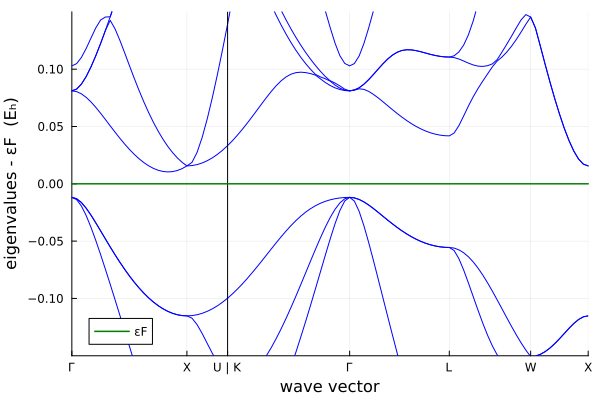

In [16]:
plot_bandstructure(bands)

To apply the same strategy as above, we are now interested in the derivative
of the whole band structure $\varepsilon_{n\mathbf{k}}$ with respect to parameters $\theta$.

In [17]:
include("compute_bands_forwarddiff.jl")

compute_bands_forwarddiff (generic function with 2 methods)

In [21]:
kgrid_bands = ExplicitKpoints(bands.kinter)

ExplicitKpoints with 109 k-points

In [ ]:
function bandstructure(a, θ)
    basis = setup_basis(a, θ; Ecut, kgrid)
    scfres = self_consistent_field(basis; tol=1e-6)
    bands = compute_bands_forwarddiff(basis, kgrid_bands; scfres.ρ, tol=1e-6)
    reduce(hcat, bands.eigenvalues)
end

bandstructure (generic function with 1 method)

In [79]:
b = bandstructure(a0, params.θ_bf)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450483854190                   -0.96    4.3    619ms
  2   -8.452393077470       -2.72       -1.81    1.0    579ms
  3   -8.452549345567       -3.81       -2.92    2.1    433ms
  4   -8.452557908544       -5.07       -3.41    3.0    558ms
  5   -8.452558005096       -7.02       -4.01    1.5    369ms
  6   -8.452558011150       -8.22       -5.18    1.9    397ms
  7   -8.452558011535       -9.41       -5.67    3.1    492ms
  8   -8.452558011538      -11.61       -6.84    1.3    352ms
scfres.εF = 0.16623946165781908


14×109 Matrix{Float64}:
 -0.280671  -0.280397  -0.279573  …  -0.130655   -0.130916   -0.131005
  0.154422   0.152424   0.146815     -0.130655   -0.130916   -0.131005
  0.154422   0.153232   0.149885      0.0479273   0.0502432   0.0510583
  0.154422   0.153232   0.149885      0.0479273   0.0502432   0.0510583
  0.247306   0.246637   0.244685      0.187779    0.18337     0.181858
  0.247306   0.248835   0.2532    …   0.187779    0.18337     0.181858
  0.247306   0.248835   0.2532        0.507994    0.516043    0.518474
  0.26909    0.271045   0.276477      0.507994    0.516043    0.518474
  0.437226   0.434992   0.4288        0.546354    0.552629    0.556265
  0.437226   0.437531   0.438446      0.546354    0.552629    0.556265
  0.445963   0.447178   0.450767  …   0.616538    0.613839    0.611359
  0.56579    0.566269   0.567704      0.616538    0.613839    0.611359
  0.56579    0.566269   0.567704      0.641591    0.629201    0.625355
  0.56579    0.567373   0.571711      0.641591    0

In [80]:
dbands = ForwardDiff.jacobian(
    θ -> bandstructure(a0, θ),
    params.θ_bf
)

n     Energy            log10(ΔE)   log10(Δρ)   Diag   Δtime
---   ---------------   ---------   ---------   ----   ------
  1   -8.450488325059                   -0.96    4.3    1.54s
  2   -8.452395183950       -2.72       -1.81    1.0    634ms
  3   -8.452549484856       -3.81       -2.92    2.0    824ms
  4   -8.452557919585       -5.07       -3.42    3.0    961ms
  5   -8.452558006052       -7.06       -4.04    1.4    377ms
  6   -8.452558011155       -8.29       -5.11    1.6    379ms
  7   -8.452558011534       -9.42       -5.53    3.0    491ms
  8   -8.452558011538      -11.39       -6.49    1.2    400ms
Solving response problem
Iter  Restart  Krydim  log10(res)  avg(CG)  Δtime   Comment
----  -------  ------  ----------  -------  ------  ---------------
                                      57.9   1.01s  Non-interacting
   1        0       1       -1.47     42.4   1.27s  
   2        0       2       -2.82     29.6   1.05s  
   3        0       3       -3.97     17.3   1.21s  
 

1526×3 Matrix{Float64}:
 -0.319037   0.00124621  0.00333987
 -0.34012   -0.00840501  0.000862589
 -0.34012   -0.00840501  0.000862589
 -0.34012   -0.00840501  0.000862589
 -0.308677   0.0067195   0.00330315
 -0.308677   0.0067195   0.00330315
 -0.308677   0.0067195   0.00330315
 -0.342578  -0.00193322  0.00275677
 -0.306496   0.00633252  0.0029484
 -0.306496   0.00633252  0.0029484
  ⋮                      
 -0.277787   0.0160087   0.00916557
 -0.327969   0.00295276  0.00217184
 -0.327969   0.00295276  0.00217184
 -0.318253  -0.00313577  0.00387132
 -0.318253  -0.00313576  0.00387133
 -0.309899   0.00560973  0.00270406
 -0.309899   0.00560973  0.00270406
 -0.319347   0.00380478  0.00649686
 -0.319347   0.00380478  0.00649686

In [82]:
dbands_reshaped = reshape(dbands, size(b)..., length(params.θ_bf))

14×109×3 Array{Float64, 3}:
[:, :, 1] =
 -0.319037  -0.319055  -0.31911   …  -0.330382  -0.330239  -0.330191
 -0.34012   -0.340156  -0.340247     -0.330382  -0.330239  -0.330191
 -0.34012   -0.339543  -0.338055     -0.319101  -0.320531  -0.321055
 -0.34012   -0.339543  -0.338055     -0.319101  -0.320531  -0.321055
 -0.308677  -0.308313  -0.307278     -0.279762  -0.278316  -0.277787
 -0.308677  -0.309258  -0.310759  …  -0.279762  -0.278316  -0.277787
 -0.308677  -0.309258  -0.310759     -0.324689  -0.327263  -0.327969
 -0.342578  -0.342546  -0.34243      -0.324689  -0.327263  -0.327969
 -0.306496  -0.305197  -0.301899     -0.318252  -0.317773  -0.318253
 -0.306496  -0.306502  -0.306517     -0.318252  -0.317773  -0.318253
 -0.239829  -0.240197  -0.241243  …  -0.312915  -0.311007  -0.309899
 -0.25991   -0.259967  -0.260139     -0.312915  -0.311007  -0.309899
 -0.25991   -0.259967  -0.260139     -0.319605  -0.319425  -0.319347
 -0.25991   -0.260563  -0.261997     -0.319605  -0.319425  -0.3

In [83]:
bands_uncertainty = [
    norm.(eachrow(dbands_reshaped[:,ik,:] * params.L))
    for ik in 1:size(b,2)
]

109-element Vector{Vector{Float64}}:
 [0.025395310393609073, 0.027212604395746146, 0.02721260437384448, 0.02721260436089172, 0.026761878567947532, 0.026761878280148196, 0.026761878263441816, 0.027176577018417667, 0.02690520921880175, 0.026905209125407073, 0.010203406459477654, 0.017202814324309864, 0.017202812712041285, 0.017202810689842144]
 [0.025397657654169774, 0.027221296073061854, 0.02717826092379101, 0.027178261003875003, 0.026665644338147734, 0.026762380929398418, 0.026762380942489762, 0.027170905238842802, 0.02663886443876852, 0.02690575445569662, 0.010244855149595009, 0.017215171144795784, 0.01721517084707857, 0.017290716177500987]
 [0.025404698394075075, 0.02724592231095819, 0.027090906808286935, 0.027090906755071423, 0.026392797658822107, 0.026766639312491892, 0.026766639299538895, 0.02715485339176283, 0.02595346938481648, 0.026907391224964043, 0.010367142041885278, 0.017252775623846833, 0.01725277565551876, 0.017462025467631825]
 [0.02541641840736996, 0.02728291487633116, 

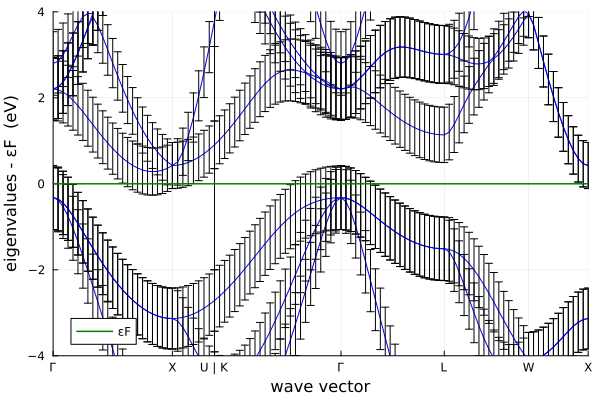

In [84]:
plot_bandstructure(
    (; bands..., eigenvalues_error=bands_uncertainty),
    unit=u"eV",
)

In [ ]:
# TODO add total derivative of band structure w.r.t. θ (including implicit dependence via lattice constant)

In [ ]:
# TODO visualize samples from the band distributions (to see smoothness/covariance)